#### Contexto
Empresas de cartão de crédito precisam identificar transações fraudulentas para evitar cobranças indevidas.

#### Conteúdo
O conjunto de dados contém transações de cartões de crédito feitas por portadores europeus em setembro de 2013. Ele inclui 492 fraudes de um total de 284.807 transações, sendo que as fraudes representam 0,172% das transações. As variáveis de entrada são numéricas e resultam de uma transformação PCA, com exceção dos recursos 'Time' (tempo em segundos desde a primeira transação) e 'Amount' (valor da transação). A variável 'Class' indica se a transação é fraudulenta (1) ou não (0). Devido ao desequilíbrio de classes, recomenda-se usar a Área Sob a Curva de Precisão-Recall (AUPRC) para avaliar a precisão, em vez da matriz de confusão.

#### Importanto dados do Kaggle

Nessa parte estamos fazendo o download do conjunto de dados para realização das análises. O arquivo que contém do conjunto de dados se chama creditcard.csv. Também aproveitamos e o adionamos em um dataframe para fazer uma análise exploratória mais aprofundadada.

In [3]:
import kagglehub as kag 
import pandas as pd

In [4]:
path = kag.dataset_download("mlg-ulb/creditcardfraud")

In [5]:
file_csv = f"{path}/creditcard.csv"

#### Quais variáveis e sua quantidade?
Nesse ponto verfficamos que o conjunto total tem 31 variáveis sendo que três delas temos conhecimentos que são a (Time - tempo em segundo dese a primeira transação), (Amount - valor da transação) e a (Class - classes da obseração sendo [0 - não fraude] e [1 - fraude]). As variáveis de V1 até V28, como no enunciado dos dados, são componentes de um PCA que foi apliado nos dados antes do mesmo ser disponibilizado.

In [6]:
df = pd.read_csv(file_csv)

In [7]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [8]:
df.columns.shape[0]

31

#### Verificando o desbalanceamento dos dados
Ao verificarmos o nível de desbalanceamento percebemoa que existem 284315 observações que representam transações to tipo não fraude e 492 transações do tipo fraude. Em termos metemáticos temos uma diferença de quantidade entre as classes de 283823 pró classes não fraude. Resumindo, temos um conjunto de dados muito desbalanceado, onde a parte de classes fraudes não é representativa, perante a classe não fraude.

In [20]:
df_count_class = pd.DataFrame(df.Class.value_counts().reset_index())
df_count_class.columns = ['Classes', 'Frequência']
df_count_class

,Classes,Frequência
0,0,284315
1,1,492


#### Verificando a distribuição das classes fraudes e e não fraudes

Visualizando as distribuições das classes fraude e não fraude

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

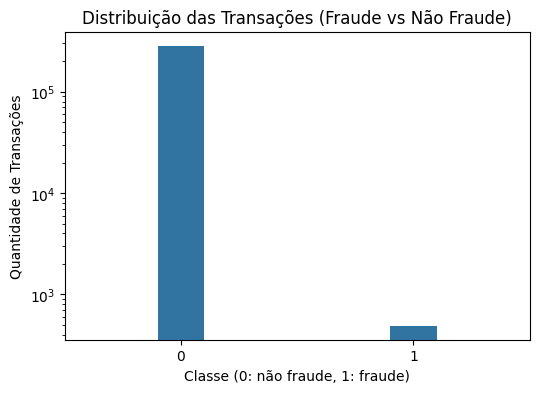

In [32]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df, width=0.2)
plt.title('Distribuição das Transações (Fraude vs Não Fraude)')
plt.xlabel('Classe (0: não fraude, 1: fraude)')
plt.ylabel('Quantidade de Transações')
plt.yscale('log')
plt.show()

#### Verificando a proporção entre classes fraude e não fraude
Verificando a proporção de fraudes, vemos que o desbalanceamento é muito significativo de aproximdamantente 0.173%

In [39]:
fraud_ratio = df[df.Class == 1].shape[0]/df[df.Class == 0].shape[0]
print(f'Proporção de fraudes: {fraud_ratio:.5f}')

Proporção de fraudes: 0.00173


#### Verificar a distribuição do valor das transações ('Amount') para fraudes e não fraudes